<center> <b>Machine Learning - SBU FALL 2024</b></center>

In [1]:
Student_Number = '400243059'
Name = 'Mohammad Moein'
Last_Name = 'Arabi'

# Connect to gDrive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os

# BASE_PATH = 'drive/MyDrive/ColabNotebooks/MNIST/'
BASE_PATH = './'
if not os.path.exists(BASE_PATH):
    raise ValueError('path does not exist')

# Imported Libraries

In [4]:
import os
import copy
import pickle

from tqdm.notebook import tqdm
import torch
import torch.nn as nn               # For building neural network layers
import torch.optim as optim         # For optimizers (SGD, Adam, etc.)
import torch.nn.functional as F     # For activation functions and other operations
from torchvision import datasets, transforms  # For MNIST dataset and data preprocessing if its needed
from torch.utils.data import DataLoader       # For batching and shuffling data

# Additional libraries for visualization and analysis
import matplotlib.pyplot as plt     # For plotting graphs and visualizations
import numpy as np                  # For numerical operations
import seaborn as sns               # For plotting the confusion matrix heatmap
from sklearn.metrics import confusion_matrix  # For computing the confusion matrix

In [ ]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

# Build a Model for the MNIST Dataset


## Objective

In this Notebook, your goal is to build a machine learning model that achieves an accuracy of **98% or higher** on the MNIST dataset. The MNIST dataset contains images of handwritten digits (0-9), and it’s a popular benchmark for evaluating classification models. To achieve this accuracy threshold, you’ll need to carefully design, train, and evaluate your model.


Using only the provided libraries, you will:
1. **Load and preprocess** the MNIST data.
2. **Build** a neural network model suitable for image classification.
3. **Train** the model on the training data, monitoring accuracy and adjusting parameters as needed.
4. **Evaluate** the model on the test data to ensure it meets the required accuracy threshold.

Each cell in this section will guide you through these steps, with descriptions explaining the purpose of each step and what you need to do. Follow the instructions carefully, and use your understanding of neural networks to achieve the best possible performance on the MNIST dataset.

## Step 1: Loading and Preprocessing the MNIST Dataset


In this cell, you will:
1. **Load the MNIST dataset**: This dataset consists of 28x28 grayscale images of handwritten digits (0–9). Each image is represented as a 28x28 array of pixel values, and each label corresponds to the digit in the image.
   
2. **Define key variables**:
   - `num_classes`: The number of unique classes in the dataset (0–9).
   - `input_shape`: The shape of each image, which will help in defining the model's input layer.
   - `num_features`: The total number of pixels in each image, useful if you need to flatten the images into a 1D vector for the model.

3. **Normalize the pixel values**: The pixel values are divided by 255 to rescale them from their original range of 0–255 to a range of 0–1. This normalization step helps the model converge faster and improves performance.

4. **One-hot encode the labels**: Convert the labels into a one-hot encoded format. Instead of representing the labels as single integers (e.g., `3` for the digit 3), one-hot encoding represents each label as a binary vector (e.g., `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]` for the digit 3). This format is commonly used for multi-class classification problems and is required for training neural networks effectively.

By the end of this cell, your data will be ready for building and training the model.

In [5]:
# Load the MNIST dataset
train, test = datasets.MNIST(root='.', train=True, download=True), datasets.MNIST(root='.', train=False, download=True)

In [6]:
x_train, y_train = torch.tensor(train.data), torch.tensor(train.targets)
x_test, y_test = torch.tensor(test.data), torch.tensor(test.targets)
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]
num_features = np.prod(input_shape)

C:\Users\asus\AppData\Local\Temp\ipykernel_23664\2191496667.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train = torch.tensor(train.data), torch.tensor(train.targets)
C:\Users\asus\AppData\Local\Temp\ipykernel_23664\2191496667.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test = torch.tensor(test.data), torch.tensor(test.targets)


In [7]:
x_train.shape

torch.Size([60000, 28, 28])

In [8]:
x_train = x_train.float()
x_test = x_test.float()
print(x_train.dtype, x_test.dtype)

torch.float32 torch.float32


In [9]:
y_train

tensor([5, 0, 4,  ..., 5, 6, 8])

In [10]:
print('Number of training samples:', len(train))
print('Number of test samples:', len(test))
print('Image shape:', input_shape)
print('Number of classes:', num_classes)
print('Number of features:', num_features)

Number of training samples: 60000
Number of test samples: 10000
Image shape: torch.Size([28, 28])
Number of classes: 10
Number of features: 784


### Plot

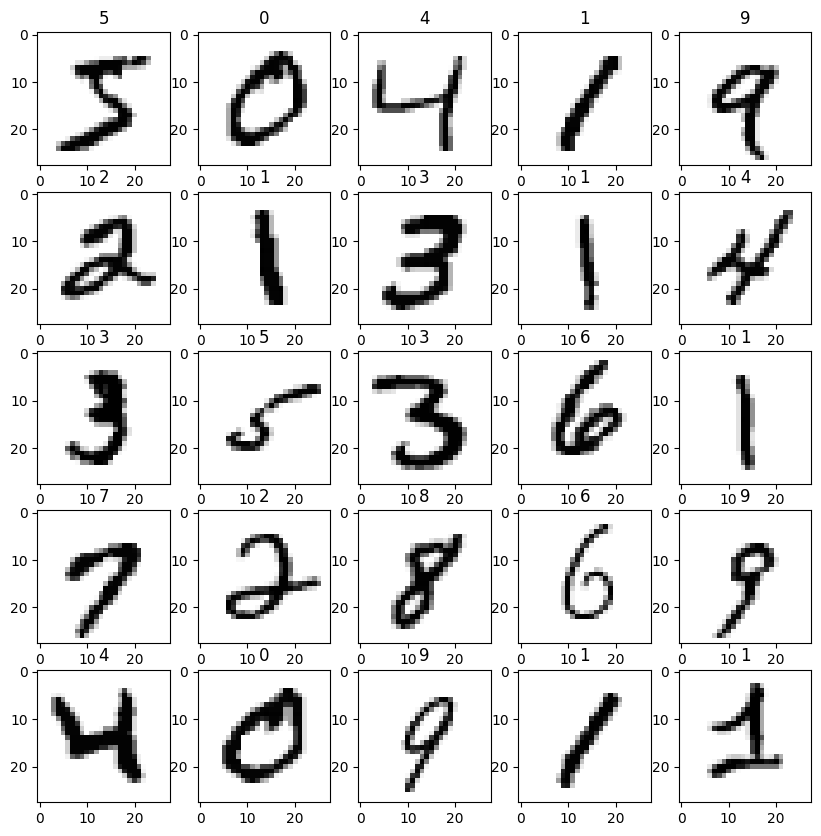

In [11]:
image_for_plot = x_train[:25, :, :].clone()
dis_center = (255 / 2) - image_for_plot
image_for_plot += dis_center*2
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_for_plot[i], cmap='gray')
    plt.title(y_train[i].item())

### Normalization

In [12]:
# Normalize the pixel values and one-hot encode the labels
x_train /= 255
x_test /= 255
assert x_train.max() <= 1.0
assert x_test.max() <= 1.0

In [13]:
# Convert labels to one-hot encoding
def one_hot(y, num_classes) -> torch.Tensor:
    one_hot = torch.zeros(num_classes)
    one_hot[y] = 1
    return one_hot

y_train = torch.stack([one_hot(y, num_classes) for y in y_train])
y_test = torch.stack([one_hot(y, num_classes) for y in y_test])

In [14]:
print(y_train.shape, y_test.shape)

torch.Size([60000, 10]) torch.Size([10000, 10])


### Move data to CUDA

In [15]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else 'cpu'
)
print(f"Using {device} device")

Using cuda device


In [16]:
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

## Step 2: Building and Optimizing Your Model for MNIST

Your goal in this cell is to build a neural network model that achieves an accuracy of **98% or higher** on the MNIST dataset. To achieve this, you will need to:
1. **Define the model architecture**: You can experiment with the number of layers, units in each layer, and other architectural details to optimize your model’s performance.
2. **Choose an optimizer**: Test different optimizers (SGD, Adagrad, RMSprop, Adam) and fine-tune their hyperparameters (such as learning rate, momentum, etc.).
3. **Search for optimal hyperparameters**: You can use hyperparameter tuning methods such as **Hyperband**, **Random Search**, or **Bayesian Optimization** to find the best hyperparameter values efficiently.

### Available Tuning Options

- **Hyperband**: Efficiently finds the best hyperparameters by exploring a wide range and narrowing down based on performance.
- **Random Search**: Tries a random combination of hyperparameters within defined ranges.
- **Bayesian Optimization**: Uses a probabilistic approach to find the best parameters based on past evaluations.

### Final Task

Once you’ve achieved a model with over **98% accuracy** on the MNIST test set:
1. **Print the optimal hyperparameters** for your best-performing model.
2. **Build and compile the model** using these optimal parameters.
3. **Display the model summary** at the end of the cell.

By following this approach, you will gain insights into how different optimizers and model configurations impact performance, ultimately helping you build an effective and efficient model for the MNIST dataset.


### if you achieve the threshold before testing all the items above you must continue and interpert the result and the change effect!

### Test how to create a model

#### Flatten the 2D image data to 1D

In [ ]:
flatten = nn.Flatten()
flat_image = flatten(x_train)
print(flat_image.shape)

torch.Size([60000, 784])


#### Making a linear layer with 20 neurons

In [ ]:
layer1 = nn.Linear(in_features=28*28, out_features=20).to(device)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([60000, 20])


In [ ]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.0498,  0.1220, -0.1009,  ..., -0.0845,  0.1286, -0.2752],
        [-0.3227, -0.0103, -0.0454,  ...,  0.1455,  0.4529, -0.0468],
        [-0.0749,  0.1968,  0.1907,  ..., -0.0693,  0.0457, -0.2613],
        ...,
        [-0.3222,  0.0809, -0.0342,  ...,  0.0495,  0.0392, -0.0666],
        [-0.4260, -0.0664,  0.0901,  ...,  0.2329,  0.3213,  0.0431],
        [-0.1841,  0.1750, -0.1880,  ..., -0.2722,  0.0164, -0.1662]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0498, 0.1220, 0.0000,  ..., 0.0000, 0.1286, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1455, 0.4529, 0.0000],
        [0.0000, 0.1968, 0.1907,  ..., 0.0000, 0.0457, 0.0000],
        ...,
        [0.0000, 0.0809, 0.0000,  ..., 0.0495, 0.0392, 0.0000],
        [0.0000, 0.0000, 0.0901,  ..., 0.2329, 0.3213, 0.0431],
        [0.0000, 0.1750, 0.0000,  ..., 0.0000, 0.0164, 0.0000]],
       device='cuda:0', grad_fn=<ReluBackward0>)


#### Sequential model layers

In [ ]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
).to(device)
logits = seq_modules(x_train[:3, :, :])

In [ ]:
print(logits.shape)
print(logits)

torch.Size([3, 10])
tensor([[-0.0808, -0.0289,  0.1610, -0.1038, -0.0605, -0.0163, -0.0705, -0.0414,
          0.0332,  0.1728],
        [-0.1193, -0.0369,  0.1432, -0.0871, -0.0392, -0.1001, -0.1650,  0.0061,
          0.0202,  0.1787],
        [-0.1757, -0.0147,  0.0954, -0.0883,  0.0088, -0.1576, -0.0902,  0.0276,
         -0.0556,  0.2117]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

In [ ]:
print(pred_probab.shape)
print(pred_probab)

torch.Size([3, 10])
tensor([[0.0922, 0.0971, 0.1174, 0.0901, 0.0940, 0.0983, 0.0931, 0.0959, 0.1033,
         0.1188],
        [0.0900, 0.0978, 0.1171, 0.0930, 0.0975, 0.0918, 0.0860, 0.1021, 0.1035,
         0.1213],
        [0.0854, 0.1003, 0.1120, 0.0932, 0.1027, 0.0869, 0.0930, 0.1046, 0.0963,
         0.1258]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


## Simple model

### Defining model 1

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
learning_rate = 0.01
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
pred = model(x_train[:3])
loss = loss_fn(pred, y_train[:3])

In [ ]:
print(f'prediction: {pred}')
print(f'label: {y_train[:3]}')
print(loss)
print(loss.shape)

prediction: tensor([[0.0980, 0.1055, 0.0977, 0.1024, 0.1120, 0.0989, 0.0992, 0.0958, 0.0943,
         0.0961],
        [0.0995, 0.1045, 0.0962, 0.1011, 0.1117, 0.1006, 0.1020, 0.0956, 0.0949,
         0.0939],
        [0.1063, 0.1050, 0.0922, 0.1029, 0.1067, 0.0987, 0.0977, 0.0963, 0.0947,
         0.0995]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
label: tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')
tensor(2.3009, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([])


In [ ]:
correct_predictions = (pred.argmax(dim=1) == y_train[:3].argmax(dim=1))
print(correct_predictions)
count = correct_predictions.type(torch.int8).sum()
print(count)

tensor([False, False,  True], device='cuda:0')
tensor(1, device='cuda:0')


### Train and test functions

In [ ]:
def train_loop(model, x_train, y_train, optimizer):
    model.train()
    pred = model(x_train)
    loss = loss_fn(pred, y_train)
    # Back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


def test_loop(model, x_test, y_test, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        pred = model(x_test)
        test_loss = loss_fn(pred, y_test).item()
        correct = (pred.argmax(dim=1) == y_test.argmax(dim=1)).type(torch.int8).sum().item()
    correct /= x_test.shape[0]
    return test_loss, correct

### Load model

In [ ]:
def load_model_from_disc(path):
    model = NeuralNetwork()
    if os.path.exists(path):
        print('Loading from disc...')
        model = torch.load(path, weights_only=False)
        model.eval()
    return model.to(device)

In [ ]:
MODEL_PATH = BASE_PATH + 'model.pt'
model_simple = load_model_from_disc(MODEL_PATH)

Loading from disc...


### Load accuracy history

In [ ]:
def load_train_hostory(path):
    accuracy_history = []
    if os.path.exists(path):
        print('Loading from disc...')
        with open(path, 'rb') as file:
            accuracy_history = pickle.load(file)
    return accuracy_history

In [ ]:
ACCURACY_PATH = BASE_PATH + 'accuracy_history.pkl'
accuracy_history = load_train_hostory(ACCURACY_PATH)

Loading from disc...


In [ ]:
%%skip
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model_simple.parameters(), lr=learning_rate)

epochs = 0

for i in tqdm(range(epochs)):
    train_loop(model_simple, x_train, y_train, optimizer)
    test_loss, accuracy = test_loop(model_simple, x_test, y_test, loss_fn)
    accuracy_history.append(accuracy)

# Save the model
torch.save(model_simple, MODEL_PATH)
with open(ACCURACY_PATH, 'wb') as f:
    pickle.dump(accuracy_history, f)

0it [00:00, ?it/s]

### plot

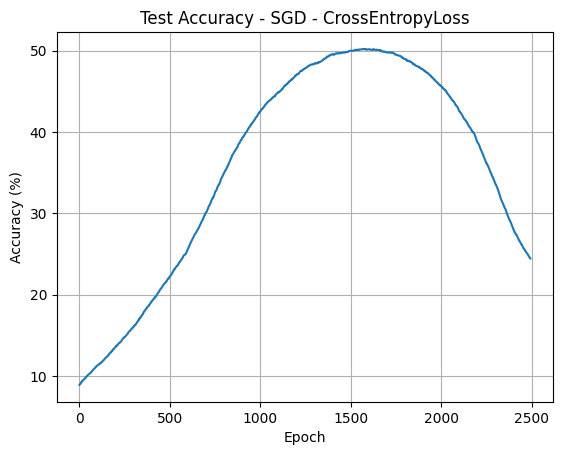

In [ ]:
plt.plot(np.arange(len(accuracy_history)), np.array(accuracy_history) * 100)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy - SGD - CrossEntropyLoss')
plt.grid()

## Mini-Batch and Early Stopping

### Define Model 2

In [17]:
class MyBaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.accuracy_train_history = []
        self.accuracy_test_history = []
        self.loss_train_history = []
        self.loss_test_history = []

    def save(self, path):
        torch.save(self, path)

    @staticmethod
    def load(path) -> nn.Module|None:
        model = None
        if os.path.exists(path):
            print(f'Loading from disc: {path}')
            model = torch.load(path, weights_only=False)
            model.eval()
        else:
            print('Model not found!')
        return model

class NeuralNetwork(MyBaseModel):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

### Load model 2

In [18]:
MODEL_PATH = BASE_PATH + 'model2_mini_batch.pt'
model = NeuralNetwork.load(MODEL_PATH)
if not model:
    model = NeuralNetwork(MODEL_PATH)
model.to(device)

Loading from disc: ./model2_mini_batch.pt


NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
    (6): Softmax(dim=1)
  )
)

### Initialize Optimizer and Loss Functions

In [26]:
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Create Mini-batch

In [27]:
batch_size = 100
x_train_batch = x_train.reshape(-1, batch_size, x_train.shape[1], x_train.shape[2])
y_train_batch = y_train.reshape(-1, batch_size, y_train.shape[1])

### Training loop with early stopping

In [28]:
def accuracy(pred, y):
    correct = (pred.argmax(dim=1) == y.argmax(dim=1)).type(torch.int8).sum().item()
    return correct / y.shape[0] # average

In [29]:
def train(model, x, y, loss_fn, optimizer):
    model.train()

    # Loop over batches
    for i in range(x.shape[0]):
        # Forward pass and loss calculation
        pred = model(x[i])
        loss = loss_fn(pred, y[i])

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [30]:
def validation(model, x, y, loss_fn):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        pred = model(x)
        loss = loss_fn(pred, y).item()
    return pred, loss

In [ ]:
%%skip
# Initialize Variables for EarlyStopping
best_loss = float('inf')
best_model_weights = copy.deepcopy(model.state_dict())
patience = 10

# Training Loop with Early Stopping:
for epoch in tqdm(range(0)):
    # Train
    train(model, x_train_batch, y_train_batch, loss_fn, optimizer)

    # Validation
    val_pred, val_loss = validation(model, x_test, y_test, loss_fn)
    train_pred, train_loss = validation(model, x_train, y_train, loss_fn)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here
        patience = 10  # Reset patience counter
    else:
        patience -= 1
        if patience == 0:
            print('Early stopping...')
            break

    # Save accuracy and loss on test
    model.accuracy_test_history.append(accuracy(val_pred, y_test))
    model.loss_test_history.append(val_loss)

    # Save accuracy and loss on train
    model.accuracy_train_history.append(accuracy(train_pred, y_train))
    model.loss_train_history.append(train_loss)


# Load the best model weights then save on disc
model.load_state_dict(best_model_weights)
model.save(MODEL_PATH)

  0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping...


### Plot

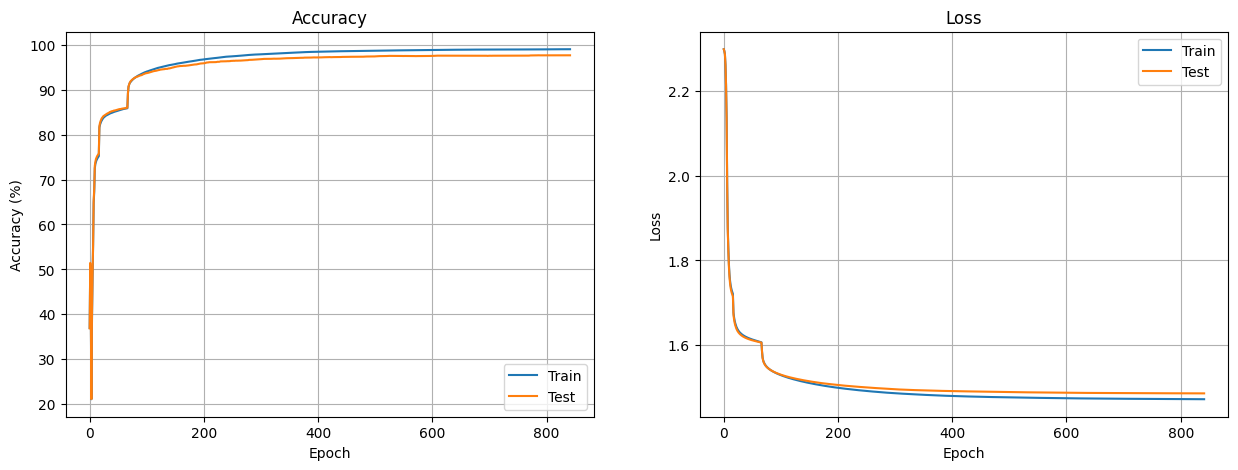

In [19]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(model.accuracy_train_history)), np.array(model.accuracy_train_history) * 100, label='Train')
plt.plot(np.arange(len(model.accuracy_test_history)), np.array(model.accuracy_test_history) * 100, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(model.loss_train_history)), np.array(model.loss_train_history), label='Train')
plt.plot(np.arange(len(model.loss_test_history)), np.array(model.loss_test_history), label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid()

In [33]:
# TODO: Define the model creation function with hyperparameters.
...

In [34]:
# TODO: Choose the hyperparameter search algorithm, define the hyperparameter search space, and tune the model.
...

In [35]:
# TODO: Evaluate the best model on the test set.
...

## Step 3: Training, Evaluating, and Saving Your Model

In this part, you will:
1. **Train the Model**: Train your model on the MNIST training data for a specified number of epochs. The `fit` function will show the training and validation accuracy/loss at each epoch, allowing you to monitor the model’s progress.
   
2. **Make Predictions**: Once training is complete, generate predictions on the test data. While not required for accuracy calculation, this can be useful if you want to further analyze the model’s predictions.

3. **Evaluate the Model**: Use the `evaluate` function to calculate the model's loss and accuracy on the test set. This will give you an objective measure of the model’s performance. Remember, the goal is to achieve **98% or higher** accuracy.

4. **Save the Model**: After achieving satisfactory accuracy, save your model to disk for later use. This allows you to load the trained model in the future without retraining.

### Important Notes:
- **Training Parameters**: You can adjust the number of epochs or batch size in the `fit` function if needed to reach the required accuracy.
- **Model Storage**: The saved model file (`mnist_model.keras`) will store the entire model structure and weights, enabling you to load and use it later without needing to rebuild or retrain.

By completing these steps, you will have a fully trained and saved model capable of achieving high accuracy on the MNIST dataset.

In [36]:
# TODO: Train the best model on the full training set.
history = ...
predictions = ...

# TODO: Evaluate the model on the test set.
loss, accuracy = ...
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy*100:.2f}%")

# TODO: Save the best model to disk.
...

TypeError: cannot unpack non-iterable ellipsis object

## Step 4: Visualizing Model Performance

In this final step, you will visualize your model's performance using a series of plots. These visualizations will help you understand how well the model performed, identify areas for potential improvement, and interpret any misclassifications.

1. **Plot the Training History**: This plot shows the training and validation accuracy over each epoch. By examining this plot, you can see how the model's accuracy improved with each epoch and check if there’s any overfitting (e.g., if training accuracy is much higher than validation accuracy).

2. **Plot the Confusion Matrix**: The confusion matrix provides a detailed view of the model's performance across each digit class (0–9). Each cell in the matrix shows the number of true vs. predicted classifications for each class. This helps you identify specific digits that the model struggles to classify correctly, as they may have higher misclassification counts.

3. **Visualize Misclassified Images**: In this grid, you’ll see some of the images that were incorrectly classified by the model. Each image shows the true label and the predicted label. Examining these misclassified examples can give you insight into where the model might have difficulty, such as digits that look similar (e.g., 3 and 5). It can also help you decide if additional data processing or model adjustments are needed.

### Tips for Interpretation:
- **Training History**: If the validation accuracy plateaus early or diverges significantly from training accuracy, consider revisiting your model architecture or hyperparameters.
- **Confusion Matrix**: Look for off-diagonal cells with high values, as these indicate common misclassifications.
- **Misclassified Images**: Understanding these cases can guide you in tuning or improving your model, such as adding more data for challenging classes.

By analyzing these plots, you’ll gain a deeper understanding of your model’s strengths and weaknesses on the MNIST dataset.

In [ ]:
# Plot the training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plot the confusion matrix heatmap
# TODO: Compute the confusion matrix using the true labels and predicted labels.
cm = ...

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Visualize the model incorrectly classified images on 4x5 grid
# TODO: Find the indices of incorrectly classified images.
incorrect_indices = ...

plt.figure(figsize=(8, 6))
for i, idx in enumerate(incorrect_indices[:20]):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_test[idx], cmap='gray')
    plt.title(f"True: {np.argmax(y_test[idx])} - Pred: {np.argmax(predictions[idx])}")
    plt.axis('off')
plt.tight_layout()
plt.show()